# Project: Amazon E-Commerce Data Analysis

## Project Phases:
- **Phase 1**: Data Collection (Rainforest API, Selenium) and Processing (cleaning, NetworkX graph).
- **Phase 2**: Visualization (NetworkX graph, heatmap for prices).
- **Phase 3**: Point Cloud Analysis and Gradio UI.

In [81]:
%pip install requests selenium pandas networkx matplotlib seaborn plotly gradio webdriver_manager
!apt-get update
!apt-get install -y chromium chromium-driver libnss3 libgconf-2-4

import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import gradio as gr
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
import re

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('window-size=1920x1080')


Note: you may need to restart the kernel to use updated packages.


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


## Phase 1: Data Collection

### Rainforest API: Fetch iPhone 14 Product Data

In [73]:
# Rainforest API configuration
RAINFOREST_API_KEY = "1951CB94DC4246D38503225430F0A0D4"  
COUNTRIES = {
    'us': 'amazon.com',
    'uk': 'amazon.co.uk',
    'de': 'amazon.de',
    'fr': 'amazon.fr',
    'jp': 'amazon.co.jp'
}
PRODUCT_QUERY = 'Apple iPhone 14'

def fetch_rainforest_data(query, country, domain):
    params = {
        'api_key': RAINFOREST_API_KEY,
        'type': 'search',
        'amazon_domain': domain,
        'search_term': query,
        'sort_by': 'price_low_to_high'
    }
    try:
        response = requests.get('https://api.rainforestapi.com/request', params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('search_results', [])
    except Exception as e:
        print(f'Error fetching data for {country}: {e}')
        return []


product_data = []
for country, domain in COUNTRIES.items():
    results = fetch_rainforest_data(PRODUCT_QUERY, country, domain)
    for item in results[:5]:  
        product_data.append({
            'title': item.get('title', 'No title'),
            'price': item.get('price', {}).get('value', 0),
            'currency': item.get('price', {}).get('currency', 'USD'),
            'rating': item.get('rating', 0),
            'reviews': item.get('reviews', 0),
            'country': country.upper(),
            'asin': item.get('asin', 'No ASIN')
        })


product_df = pd.DataFrame(product_data)
print('Collected Product Data:')
print(product_df.head())


product_df.to_csv('iphone_14_data.csv', index=False)

Collected Product Data:
                                               title   price currency  rating  \
0  Apple iPhone SE (2nd Generation), 64GB, Red - ...  100.00      USD     4.2   
1  Apple iPhone 11 [64GB, Black] + Carrier Subscr...   91.39      USD     4.4   
2  Apple iPhone XR, US Version, 64GB, Black - AT&...  164.90      USD     4.4   
3  Apple iPhone XS, US Version, 64GB, Space Gray ...  159.90      USD     4.3   
4  Apple iPhone 11 Pro Max [64GB, Space Gray] + C...  148.72      USD     3.6   

   reviews country        asin  
0        0      US  B088N8TF64  
1        0      US  B0844NJJF3  
2        0      US  B07T1L2SBK  
3        0      US  B07K8RQVHF  
4        0      US  B084GSPKMV  


### Selenium: Scrape Dynamic Content


In [74]:
def scrape_frequently_bought_together(asin, country='com'):
    url = f'https://www.amazon.{country}/dp/{asin}'
    try:
        driver.get(url)
        time.sleep(5)  
        
        related_items = []
        elements = driver.find_elements(By.CSS_SELECTOR, 'div#desktop_buybox_btf div.a-section span')
        for elem in elements:
            text = elem.text
            if 'Frequently bought together' in text:
                # Extract related product titles
                related_elements = driver.find_elements(By.CSS_SELECTOR, 'div#desktop_buybox_btf div.a-section a')
                for rel_elem in related_elements:
                    title = rel_elem.text.strip()
                    if title and title not in related_items:
                        related_items.append(title)
        return related_items
    except Exception as e:
        print(f'Error scraping {url}: {e}')
        return []

sample_asin = product_df[product_df['country'] == 'US']['asin'].iloc[0] if not product_df.empty else 'B08X9Y9Z1A'
related_items = scrape_frequently_bought_together(sample_asin, 'com')
print('Frequently Bought Together Items:')
print(related_items)

driver.quit()

Frequently Bought Together Items:
[]


## Phase 1: Data Processing

### Clean and Preprocess Data

In [75]:
product_df['price'] = product_df['price'].fillna(0)
product_df['rating'] = product_df['rating'].fillna(0)
product_df['reviews'] = product_df['reviews'].fillna(0)

conversion_rates = {'USD': 1, 'GBP': 1.3, 'EUR': 1.1, 'JPY': 0.0067}
product_df['price_usd'] = product_df.apply(
    lambda row: row['price'] * conversion_rates.get(row['currency'], 1), axis=1
)

print('Cleaned DataFrame:')
print(product_df[['title', 'price', 'currency', 'price_usd', 'country']].head())

Cleaned DataFrame:
                                               title   price currency  \
0  Apple iPhone SE (2nd Generation), 64GB, Red - ...  100.00      USD   
1  Apple iPhone 11 [64GB, Black] + Carrier Subscr...   91.39      USD   
2  Apple iPhone XR, US Version, 64GB, Black - AT&...  164.90      USD   
3  Apple iPhone XS, US Version, 64GB, Space Gray ...  159.90      USD   
4  Apple iPhone 11 Pro Max [64GB, Space Gray] + C...  148.72      USD   

   price_usd country  
0     100.00      US  
1      91.39      US  
2     164.90      US  
3     159.90      US  
4     148.72      US  


### Construct NetworkX Graph

In [76]:
G = nx.Graph()


for _, row in product_df.iterrows():
    G.add_node(row['asin'], title=row['title'], country=row['country'])


print('Inspecting product_df for edge creation:')
print(product_df[['asin', 'title', 'country']].head(10))  
edge_count = 0
for i, row1 in product_df.iterrows():
    for j, row2 in product_df.iterrows():
        if i < j:  
            if row1['country'] == row2['country']:
                title1 = row1['title'].lower()
                title2 = row2['title'].lower()
                if 'iphone' in title1 and 'iphone' in title2:
                    G.add_edge(row1['asin'], row2['asin'], relationship='same_country_iphone')
                    edge_count += 1
                    print(f'Added edge: {row1["title"][:20]} - {row2["title"][:20]} (Country: {row1["country"]})')

print(f'Total edges added: {edge_count}')

Inspecting product_df for edge creation:
         asin                                              title country
0  B088N8TF64  Apple iPhone SE (2nd Generation), 64GB, Red - ...      US
1  B0844NJJF3  Apple iPhone 11 [64GB, Black] + Carrier Subscr...      US
2  B07T1L2SBK  Apple iPhone XR, US Version, 64GB, Black - AT&...      US
3  B07K8RQVHF  Apple iPhone XS, US Version, 64GB, Space Gray ...      US
4  B084GSPKMV  Apple iPhone 11 Pro Max [64GB, Space Gray] + C...      US
5  B0797QCXS6         Apple iPhone 8, 64GB, Space Grey (Renewed)      UK
6  B08D351RSN  Apple iPhone SE 2nd generation, 64 GB, Red (Re...      UK
7  B08D34BNKP  Apple iPhone SE 2nd Generation, 64GB, Black (R...      UK
8  B08D2N6P3X  Apple iPhone SE (2nd Gen) 128GB - (PRODUCT)RED...      UK
9  B08D33VS6H  Apple iPhone SE 2nd Generation, 64GB, White (R...      UK
Added edge: Apple iPhone SE (2nd - Apple iPhone 11 [64G (Country: US)
Added edge: Apple iPhone SE (2nd - Apple iPhone XR, US  (Country: US)
Added edge: Appl

## Phase 2: Visualization

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\1941683787.py:7: UserWarning:

Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\1941683787.py:7: UserWarning:

Glyph 25972 (\N{CJK UNIFIED IDEOGRAPH-6574}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\1941683787.py:7: UserWarning:

Glyph 20633 (\N{CJK UNIFIED IDEOGRAPH-5099}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\1941683787.py:7: UserWarning:

Glyph 28168 (\N{CJK UNIFIED IDEOGRAPH-6E08}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\1941683787.py:7: UserWarning:

Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\1941683787.py:7: UserWarning:

Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipyke

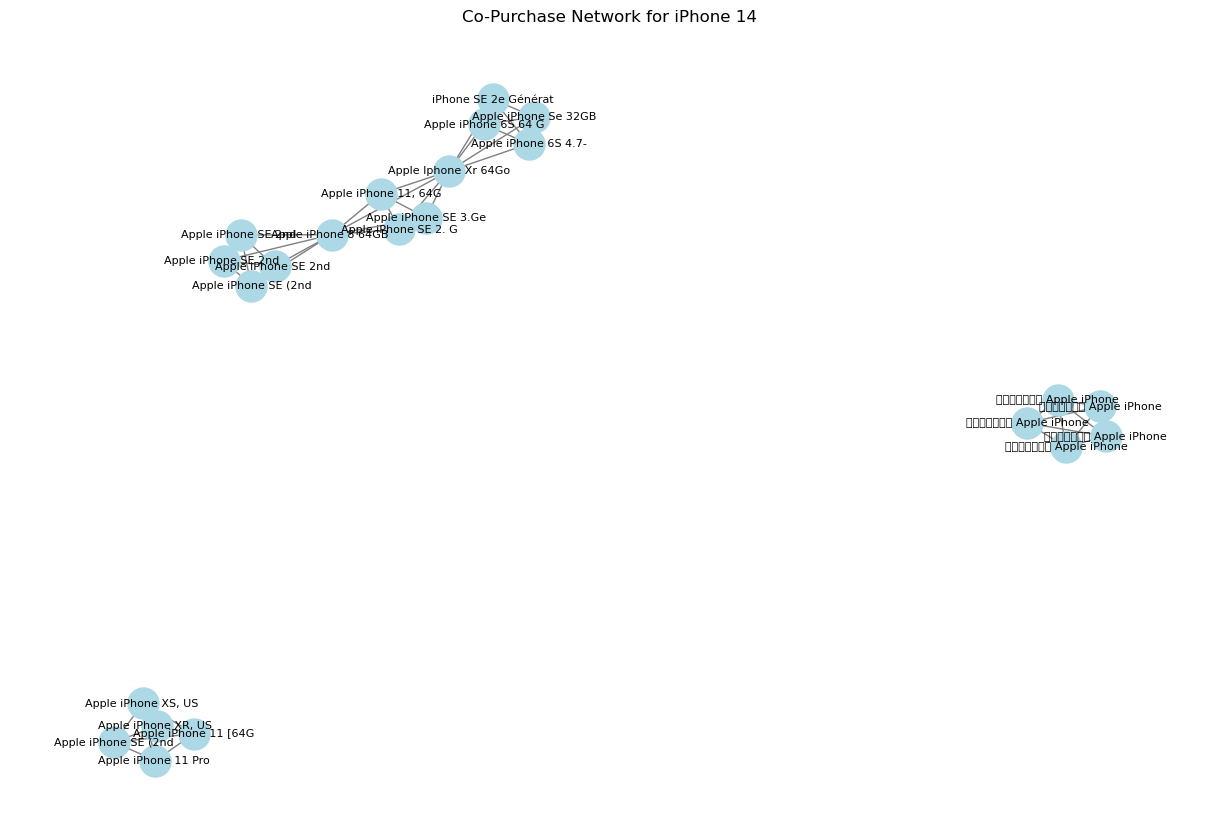

Top 5 Nodes by Degree Centrality:
Apple iPhone 8 64GB : 0.364
Apple Iphone Xr 64Go: 0.364
Apple iPhone SE (2nd: 0.182
Apple iPhone 11 [64G: 0.182
Apple iPhone XR, US : 0.182


In [77]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=500)
labels = {node: G.nodes[node]['title'][:20] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)
plt.title('Co-Purchase Network for iPhone 14')
plt.savefig('network_graph.png', dpi=300)
plt.show()

centrality = nx.degree_centrality(G)
print('Top 5 Nodes by Degree Centrality:')
for node, score in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f'{G.nodes[node]["title"][:20]}: {score:.3f}')

### Heatmap: Price Distribution Across Countries

c:\Users\darwi\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.

c:\Users\darwi\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 25972 (\N{CJK UNIFIED IDEOGRAPH-6574}) missing from font(s) DejaVu Sans.

c:\Users\darwi\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 20633 (\N{CJK UNIFIED IDEOGRAPH-5099}) missing from font(s) DejaVu Sans.

c:\Users\darwi\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 28168 (\N{CJK UNIFIED IDEOGRAPH-6E08}) missing from font(s) DejaVu Sans.

c:\Users\darwi\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.

c:\Users\darwi\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from font(s) DejaVu Sans.

c:\Users\darwi\anaconda3\Lib\site-packages\seaborn\utils.

Unique countries in product_df: ['US' 'UK' 'DE' 'FR' 'JP']
Unique titles in product_df: ['Apple iPhone SE (2nd Generation), 64GB, Red - Unlocked (Renewed)'
 'Apple iPhone 11 [64GB, Black] + Carrier Subscription [Cricket Wireless]'
 'Apple iPhone XR, US Version, 64GB, Black - AT&T (Renewed)'
 'Apple iPhone XS, US Version, 64GB, Space Gray - Verizon (Renewed)'
 'Apple iPhone 11 Pro Max [64GB, Space Gray] + Carrier Subscription [Cricket Wireless]'
 'Apple iPhone 8, 64GB, Space Grey (Renewed)'
 'Apple iPhone SE 2nd generation, 64 GB, Red (Renewed)'
 'Apple iPhone SE 2nd Generation, 64GB, Black (Renewed)'
 'Apple iPhone SE (2nd Gen) 128GB - (PRODUCT)RED (Renewed)'
 'Apple iPhone SE 2nd Generation, 64GB, White (Renewed)'
 'Apple iPhone 8 64GB Space Grey (Generalüberholt)'
 'Apple iPhone SE 2. Generation, 64GB, Weiß - (Generalüberholt) DE'
 'Apple iPhone XR 64GB Schwarz - (Generalüberholt)'
 'Apple iPhone 11, 64GB, Schwarz (Generalüberholt)'
 'Apple iPhone SE 3.Generation 64GB - Mitternachtsb

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\2267475433.py:38: UserWarning:

Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\2267475433.py:38: UserWarning:

Glyph 25972 (\N{CJK UNIFIED IDEOGRAPH-6574}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\2267475433.py:38: UserWarning:

Glyph 20633 (\N{CJK UNIFIED IDEOGRAPH-5099}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\2267475433.py:38: UserWarning:

Glyph 28168 (\N{CJK UNIFIED IDEOGRAPH-6E08}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\2267475433.py:38: UserWarning:

Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp\ipykernel_17308\2267475433.py:38: UserWarning:

Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from font(s) DejaVu Sans.

C:\Users\darwi\AppData\Local\Temp

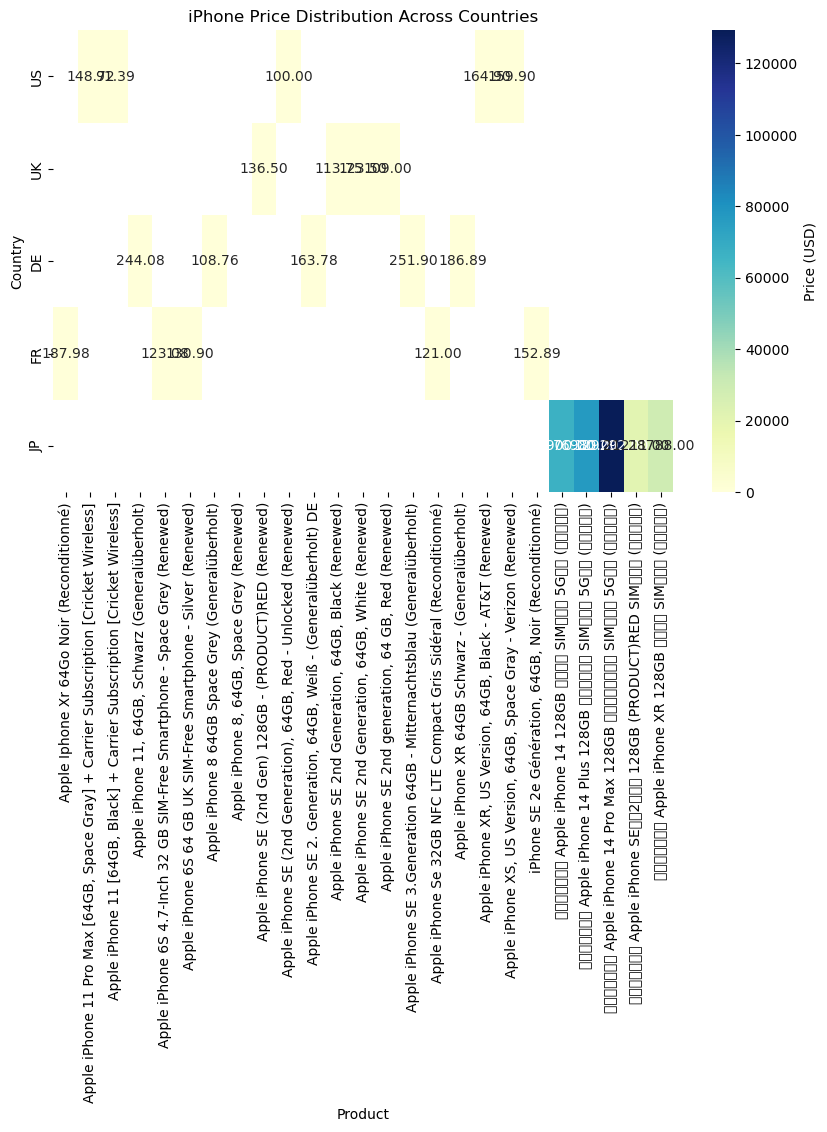

In [78]:

print('Unique countries in product_df:', product_df['country'].unique())
print('Unique titles in product_df:', product_df['title'].unique())
print('Rows with zero price_usd:', (product_df['price_usd'] == 0).sum())

heatmap_data = product_df.pivot_table(
    values='price_usd',
    index='country',
    columns='title',
    aggfunc='mean'
).fillna(0)


expected_countries = ['US', 'UK', 'DE', 'FR', 'JP']
heatmap_data = heatmap_data.reindex(expected_countries, fill_value=0)
iphone_cols = [col for col in heatmap_data.columns if 'iphone' in col.lower()]
if not iphone_cols:
    print('Warning: No titles contain "iPhone". Using all titles as fallback.')
    iphone_cols = heatmap_data.columns
heatmap_data = heatmap_data[iphone_cols]


if heatmap_data.empty or (heatmap_data == 0).all().all():
    print('Error: Heatmap data is empty or all zeros. Check product_df content.')
else:
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap='YlGnBu',
        fmt='.2f',
        cbar_kws={'label': 'Price (USD)'},
        vmin=0,  
        mask=heatmap_data == 0 
    )
    plt.title('iPhone Price Distribution Across Countries')
    plt.xlabel('Product')
    plt.ylabel('Country')
    plt.savefig('price_heatmap.png', dpi=300)
    plt.show()

## Phase 3: Point Cloud Analysis

In [79]:
print('3D Scatter Plot Data Inspection:')
print('Unique countries:', product_df['country'].unique())
print('Price USD range:', product_df['price_usd'].min(), 'to', product_df['price_usd'].max())
print('Rating range:', product_df['rating'].min(), 'to', product_df['rating'].max())
print('Reviews range:', product_df['reviews'].min(), 'to', product_df['reviews'].max())
print('Rows with zero price_usd:', (product_df['price_usd'] == 0).sum())
print('Rows with zero rating:', (product_df['rating'] == 0).sum())
print('Rows with zero reviews:', (product_df['reviews'] == 0).sum())

valid_df = product_df[
    (product_df['price_usd'] > 0) & 
    (product_df['price_usd'] < 5000) &  
    (product_df['rating'] > 0)
].copy()


valid_df['reviews_adjusted'] = valid_df['reviews'] + 1 

if valid_df.empty:
    print('Error: No valid data for 3D scatter plot (all price_usd or rating are zero or missing).')
else:
    print('Valid data for plotting:')
    print(valid_df[['title', 'country', 'price_usd', 'rating', 'reviews_adjusted']].head())
    
    fig = px.scatter_3d(
        valid_df,
        x='price_usd',
        y='rating',
        z='reviews_adjusted',
        color='country',
        size='price_usd',
        size_max=20,
        opacity=0.7,
        hover_data=['title'],
        title='3D Point Cloud: iPhone Price, Rating, Reviews'
    )
    fig.update_layout(
        scene=dict(
            xaxis_title='Price (USD)',
            yaxis_title='Rating',
            zaxis_title='Reviews (Adjusted)',
            xaxis=dict(range=[0, valid_df['price_usd'].max() * 1.1]),
            yaxis=dict(range=[0, 5.5]),
            zaxis=dict(range=[0, valid_df['reviews_adjusted'].max() * 1.1], type='log') 
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )
    fig.write_html('point_cloud.html')
    fig.show()

3D Scatter Plot Data Inspection:
Unique countries: ['US' 'UK' 'DE' 'FR' 'JP']
Price USD range: 0.0 to 129292.0
Rating range: 3.0 to 5.0
Reviews range: 0 to 0
Rows with zero price_usd: 1
Rows with zero rating: 0
Rows with zero reviews: 25
Valid data for plotting:
                                               title country  price_usd  \
0  Apple iPhone SE (2nd Generation), 64GB, Red - ...      US     100.00   
1  Apple iPhone 11 [64GB, Black] + Carrier Subscr...      US      91.39   
2  Apple iPhone XR, US Version, 64GB, Black - AT&...      US     164.90   
3  Apple iPhone XS, US Version, 64GB, Space Gray ...      US     159.90   
4  Apple iPhone 11 Pro Max [64GB, Space Gray] + C...      US     148.72   

   rating  reviews_adjusted  
0     4.2                 1  
1     4.4                 1  
2     4.4                 1  
3     4.3                 1  
4     3.6                 1  


## Phase 3: User Interface with Gradio

In [80]:
import gradio as gr
import pandas as pd
import requests

RAINFOREST_API_KEY = "1951CB94DC4246D38503225430F0A0D4"
COUNTRIES = {
    'us': 'amazon.com',
    'uk': 'amazon.co.uk',
    'de': 'amazon.de',
    'fr': 'amazon.fr',
    'jp': 'amazon.co.jp'
}
PRODUCT_QUERY = 'Apple iPhone 14'

def fetch_rainforest_data(query, country, domain):
    params = {
        'api_key': RAINFOREST_API_KEY,
        'type': 'search',
        'amazon_domain': domain,
        'search_term': query,
        'sort_by': 'price_low_to_high'
    }
    try:
        response = requests.get('https://api.rainforestapi.com/request', params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('search_results', [])
    except Exception as e:
        print(f'Error fetching data for {country}: {e}')
        return []

def analyze_product(product_query):
    product_data = []
    for country, domain in COUNTRIES.items():
        results = fetch_rainforest_data(product_query, country, domain)
        for item in results[:5]:  
            product_data.append({
                'title': item.get('title', 'No title'),
                'price': item.get('price', {}).get('value', 0),
                'currency': item.get('price', {}).get('currency', 'USD'),
                'rating': item.get('rating', 0),
                'reviews': item.get('reviews', 0),
                'country': country.upper(),
                'asin': item.get('asin', 'No ASIN')
            })

    product_df = pd.DataFrame(product_data)
    summary = f'Found {len(product_df)} products for "{product_query}":\n'
    summary += f'Average Price (USD): ${product_df["price"].mean():.2f}\n'
    summary += f'Average Rating: {product_df["rating"].mean():.2f}\n'
    summary += f'Total Reviews: {product_df["reviews"].sum()}\n'
    return summary


iface = gr.Interface(
    fn=analyze_product,
    inputs=gr.Textbox(label='Enter Product Query (e.g., iPhone 14)'),
    outputs=gr.Textbox(label='Analysis Results'),
    title='Amazon Product Analysis'
)

iface.launch(share=False)

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
